In [27]:
import os
import keras
from keras import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
from keras.layers.convolutional import Conv2DTranspose , Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from skimage.io import imsave, imread
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.layers import concatenate
from keras.optimizers import Adam
%matplotlib inline 


np.random.seed(1337)

In [11]:
data_dir = '/home/harry/viii sem/AI'

input_dir = data_dir + '/melanoma'
other_dir = data_dir + '/others'

train_dir = data_dir + '/gt'

image_height=224
image_width=224

In [12]:
def load_data():
    total=len(os.listdir(input_dir))+len(os.listdir(other_dir))
    print(total)
    imgs=[]
    imgs_mask=[]
    i = 0

    images = os.listdir(input_dir)
    for image_name in images:
        image_mask_name = image_name.split('.')[0]
        image_mask_name = image_mask_name+"_segmentation.png"
        
        img = cv2.imread(os.path.join(input_dir, image_name),0)
        img = cv2.resize(img, (image_height, image_width))
  
        img_mask = cv2.imread(os.path.join(train_dir, image_mask_name),-1)
        img_mask=cv2.resize(img_mask,(image_height,image_width))
        ret3,img_mask = cv2.threshold(img_mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        img = img_to_array(img)
        img_mask=img_to_array(img_mask)
        
        imgs.append(img)
        imgs_mask.append(img_mask)
        
        #print('Done: {0}/{1} images'.format(i, total))
        i += 1
    images = os.listdir(other_dir)
    for image_name in images:
        
        image_mask_name = image_name.split('.')[0] 
        image_mask_name = image_mask_name+"_segmentation.png"
        
        img = cv2.imread(os.path.join(other_dir, image_name),0)
        img = cv2.resize(img, (image_height, image_width))
        img_mask = cv2.imread(os.path.join(train_dir, image_mask_name),-1)
        img_mask=cv2.resize(img_mask,(image_height,image_width))
        
        ret3,img_mask = cv2.threshold(img_mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        img = img_to_array(img)
        img_mask=img_to_array(img_mask)
        
        imgs.append(img)
        imgs_mask.append(img_mask)
        
        #print('Done: {0}/{1} images'.format(i, total))
        i += 1

    imgs = np.array(imgs, dtype="float")/255
    imgs_mask = np.array(imgs_mask,dtype="float")/255
    print('Loaded all images..')
    return imgs, imgs_mask

X, Y = load_data()

2000
Loaded all images..


In [13]:
np.save('training_imageset.npy', X)
np.save('training_image_mask.npy', Y)

In [3]:
#X = np.load('imgs_train.npy')
#Y = np.load('imgs_mask_train.npy')

In [14]:
(trainX, testX, trainY, testY) = train_test_split(X,Y, test_size=0.25, random_state=42)

In [15]:
print(trainX.shape)

(1500, 224, 224, 1)


In [16]:
print(np.unique(trainY))

[ 0.  1.]


In [17]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

In [18]:
def get_unet():
	inputs = Input((None, None, 1))
	conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
	conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
	pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

	conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
	conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
	pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

	conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
	conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
	pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

	conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
	conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
	pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

	conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
	conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

	up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
	conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
	conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

	up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
	conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
	conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

	up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
	conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
	conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

	up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
	conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
	conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

	conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

	model = Model(inputs=[inputs], outputs=[conv10])

    
    
	model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef,'accuracy'])
	
	return model
	


In [19]:
model = get_unet()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 3 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [20]:
classifier = model.fit(trainX,trainY, batch_size = 32, epochs = 25, verbose = 1, validation_data = (testX, testY))

Train on 1500 samples, validate on 500 samples
Epoch 1/25
1500/1500 [==============================] - 888s 592ms/step - loss: 1.2802 - dice_coef: 0.2803 - acc: 0.4224 - val_loss: 1.3097 - val_dice_coef: 0.2717 - val_acc: 0.2001
Epoch 2/25
1500/1500 [==============================] - 879s 586ms/step - loss: 1.2707 - dice_coef: 0.2820 - acc: 0.2033 - val_loss: 1.3059 - val_dice_coef: 0.2727 - val_acc: 0.1873
Epoch 3/25
1500/1500 [==============================] - 878s 585ms/step - loss: 1.2678 - dice_coef: 0.2834 - acc: 0.1962 - val_loss: 1.2897 - val_dice_coef: 0.2773 - val_acc: 0.1872
Epoch 4/25
1500/1500 [==============================] - 878s 585ms/step - loss: 1.1516 - dice_coef: 0.3193 - acc: 0.1962 - val_loss: 1.1376 - val_dice_coef: 0.3233 - val_acc: 0.1872
Epoch 5/25
1500/1500 [==============================] - 877s 585ms/step - loss: 1.0327 - dice_coef: 0.3600 - acc: 0.3056 - val_loss: 0.9185 - val_dice_coef: 0.4017 - val_acc: 0.6468
Epoch 6/25
1500/1500 [=====================

In [21]:
PredY = model.predict(testX,verbose="True")

In [22]:
out_image = PredY[0] 
print(out_image.shape)
print('max    value..')
print(max(out_image[0].flatten()))
image = out_image[0]
image[image > 0.5] = 255.
image[image <= 0.5] = 0
cv2.imwrite("predicted_image.png",image)

(224, 224, 1)
max    value..
0.34462


True

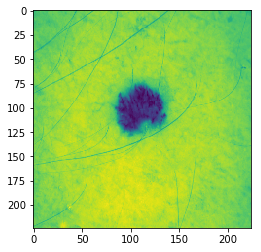

In [28]:
plt.imshow(testX[0,:,:,0])

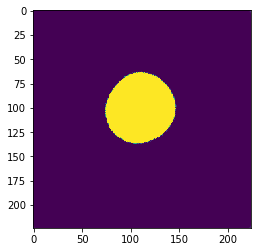

In [30]:
plt.imshow(PredY[0,:,:,0])

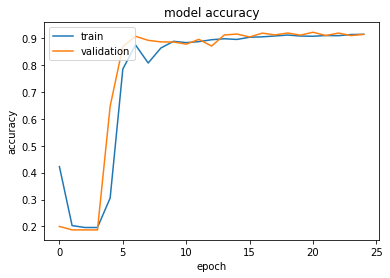

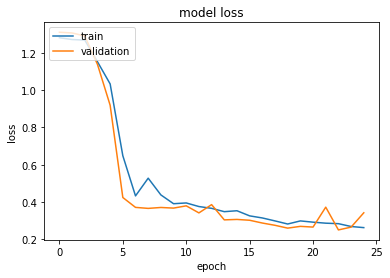

In [31]:
plt.plot(classifier.history['acc'])
plt.plot(classifier.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
#Test accuracy
classifier.history['val_acc'][24]

0.91405676460266116